In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor


sns.set_style("whitegrid")

In [2]:
bikes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', encoding='latin1')

# Make the names of the columns less cumbersome and standardized
bikes.rename(columns={'Date' : 'date', 'Hour' : 'hour', 'Rented Bike Count': 'bike_count', 'Temperature(°C)': 'temperature', 'Humidity(%)':'humidity', 'Wind speed (m/s)': 'wind_speed', 'Visibility (10m)': 'visibility', 'Dew point temperature(°C)': 'dew_point_temp', 'Solar Radiation (MJ/m2)': 'solar_radiation', 'Rainfall(mm)' : 'rainfall', 'Snowfall (cm)' : 'snowfall', 'Seasons' : 'season', 'Holiday' : 'holiday', 'Functioning Day' :'functioning_day'}, inplace=True)



# EDA

In [3]:
# Create new columns with info on whether the day was a weekday, and what day of the week it was

bikes['date'] = pd.to_datetime(bikes['date'], format='%d/%m/%Y') # Convert the date column to datetime

bikes['weekday'] = (bikes['date'].dt.weekday < 5).map({True: 'Yes', False: 'No'})  # Create a new column indicating whether it was a weekday

bikes['day_of_week'] = bikes['date'].dt.day_name() # Create a new column indicating the day of the week

In [ ]:
bikes.sample(5)

date  bike_count  hour  temperature  humidity  wind_speed  \
5069 2018-06-30         247     5         21.7        88         0.6   
670  2017-12-28         285    22          0.0        63         1.3   
6554 2018-08-31         381     2         23.4        79         0.4   
7531 2018-10-10        1723    19         11.3        50         1.1   
7704 2018-10-18         694     0          9.2        64         0.7   

      visibility  dew_point_temp  solar_radiation  rainfall  snowfall  season  \
5069         289            19.6              0.0       0.0       0.0  Summer   
670          968            -6.2              0.0       0.0       0.0  Winter   
6554        1045            19.5              0.0       0.0       0.0  Summer   
7531        2000             1.2              0.0       0.0       0.0  Autumn   
7704        2000             2.7              0.0       0.0       0.0  Autumn   

         holiday functioning_day weekday day_of_week  
5069  No Holiday             Yes      No    Saturday  
670   No Holiday             Yes     Yes    Thursday  
6554  No Holiday             Yes     Yes      Friday  
7531  No Holiday             Yes     Yes   Wednesday  
7704  No Holiday             Yes     Yes    Thursday

In [ ]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             8760 non-null   datetime64[ns]
 1   bike_count       8760 non-null   int64         
 2   hour             8760 non-null   int64         
 3   temperature      8760 non-null   float64       
 4   humidity         8760 non-null   int64         
 5   wind_speed       8760 non-null   float64       
 6   visibility       8760 non-null   int64         
 7   dew_point_temp   8760 non-null   float64       
 8   solar_radiation  8760 non-null   float64       
 9   rainfall         8760 non-null   float64       
 10  snowfall         8760 non-null   float64       
 11  season           8760 non-null   object        
 12  holiday          8760 non-null   object        
 13  functioning_day  8760 non-null   object        
 14  weekday          8760 non-null   object 

## Feature Descriptions:



*   `date` Represents the date and time of the observation
*   `bike_count` Indicates the number of bikes rented during a specific date and time
*   `hour` Represents the hour (24-hour format) of the day when the observation was made 
*   `temperature` Indicates the temperature recorded during the observation (in Celsius)
*   `humidity` Represents the humidity level recorded during the observation
*   `wind_speed` Indicates the wind speed measured during the observation (in m/s)
*   `visibility` Represents the visibility level recorded during the observation (10m)
*   `dew_point_temp` Indicates the dew point temperature recorded during the observation (in Celsius)
*   `solar_radiation` Represents the amount of solar radiation recorded during the observation (in MJ/m2)
*   `rainfall` Indicates the amount of rainfall recorded during the observation (in mm)
*   `snowfall` Represents the amount of snowfall recorded during the observation (in cm)
*   `season` Indicates the season when the observation was made
*    `holiday` Represents whether the observation date was a holiday or not
*    `functioning_day` Indicates whether the observation date was a functioning day or not
*    `weekday` Indicates whether the day is a weekday
*    `day_of_week` Indicates the day of the week when the observation was made



In [5]:
continuous_features = ['hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall']
categorical_features = ['season', 'holiday', 'functioning_day', 'weekday', 'day_of_week']

all_features = continuous_features + categorical_features


In [6]:
bikes_train, bikes_test = train_test_split(bikes.copy(),
                                           test_size = 0.2,
                                           random_state=2023,
                                           shuffle=True)

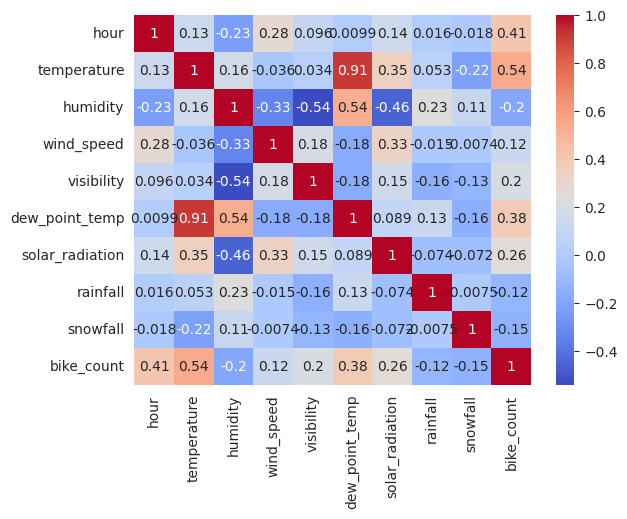

In [ ]:
# Calculate correlation matrix
correlation_matrix = bikes_train[continuous_features + ['bike_count']].corr()

# Create correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

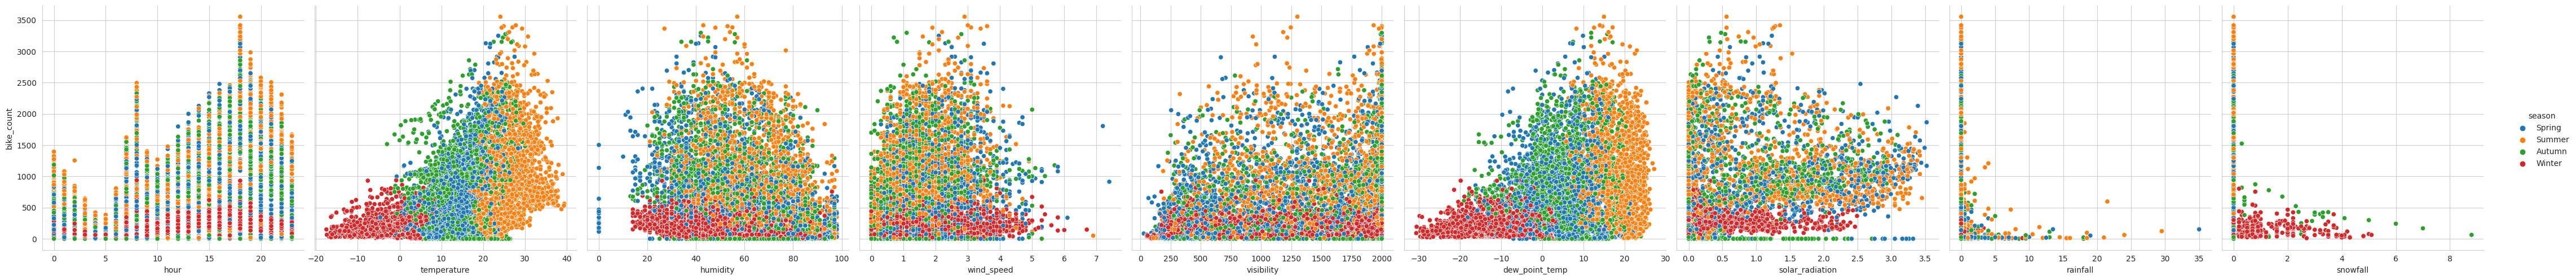

In [ ]:
# Pairplot, season as hue

sns.pairplot(bikes_train,
             x_vars = continuous_features,
             y_vars = ['bike_count'],
             hue = 'season',
             height = 5)

plt.show()

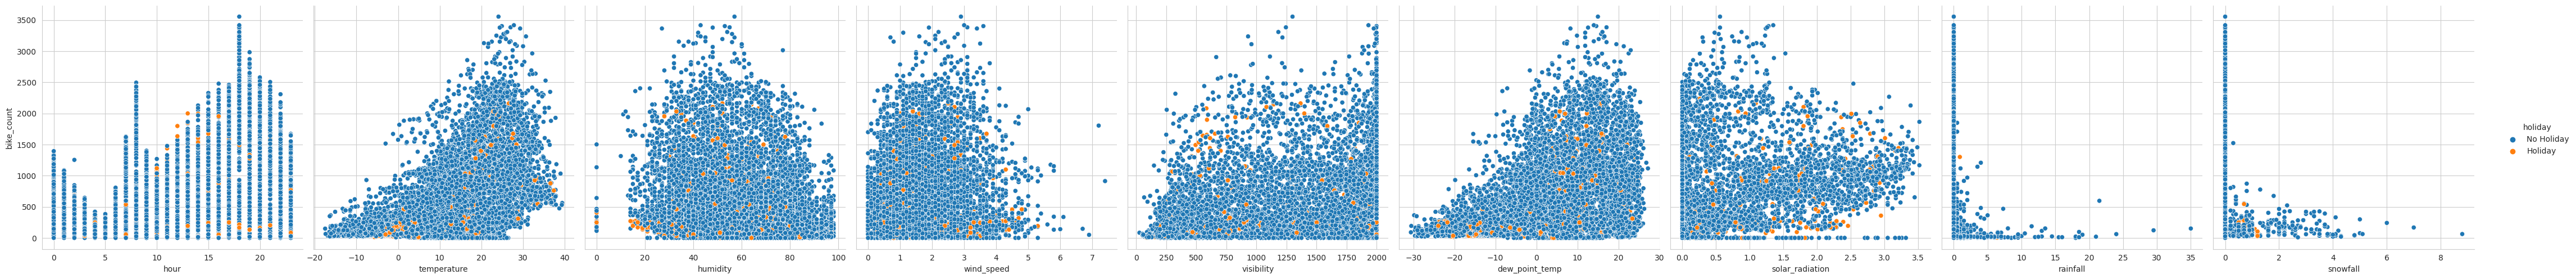

In [ ]:
# Pairplot, holiday as hue

sns.pairplot(bikes_train,
             y_vars = ['bike_count'],
             x_vars = continuous_features,
             hue = 'holiday',
             height = 5)

plt.show()

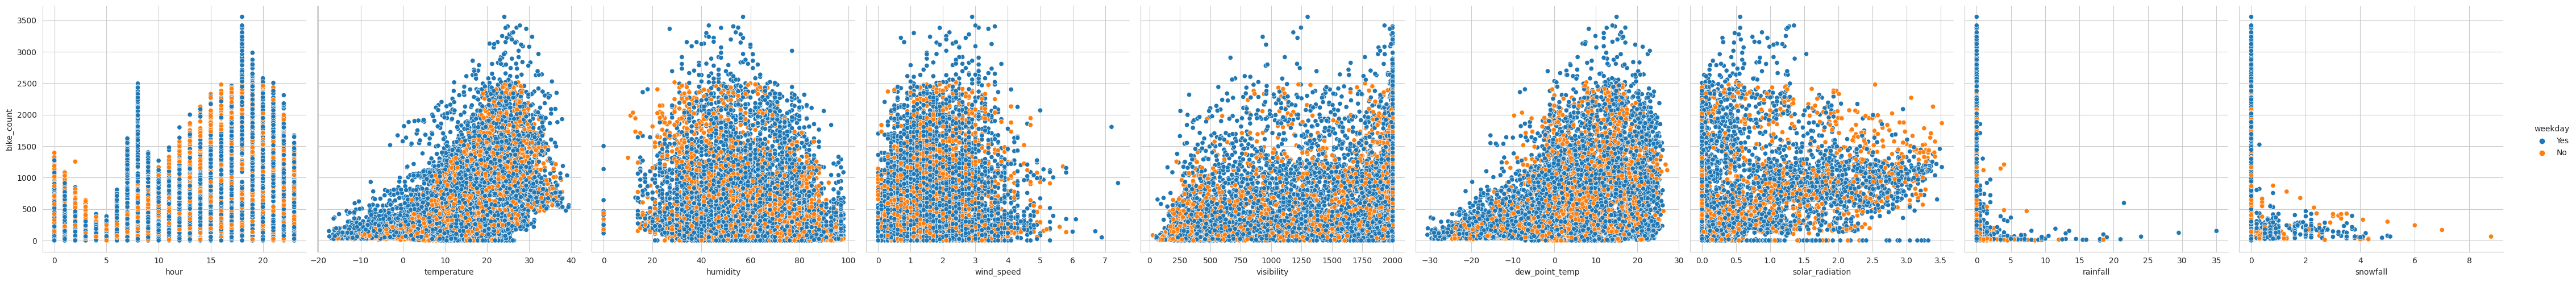

In [ ]:
# Pairplot, weekday as hue

sns.pairplot(bikes_train,
             y_vars = ['bike_count'],
             x_vars = continuous_features,
             hue = 'weekday',
             height = 5)

plt.show()

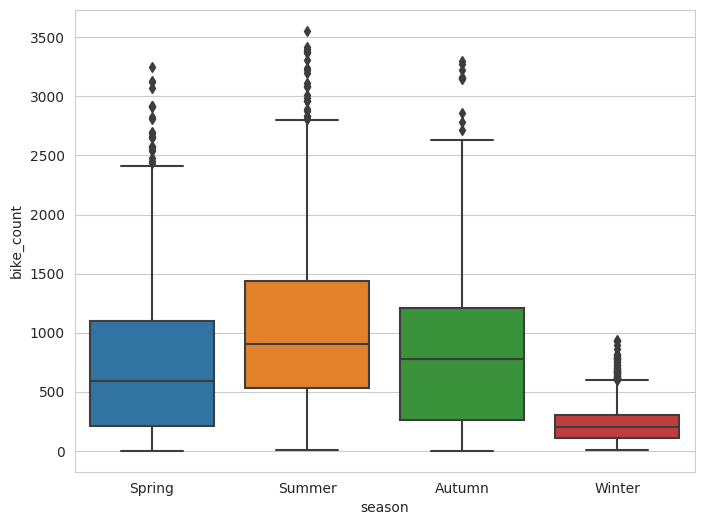

In [ ]:
# Boxplot for season:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'season')

plt.xlabel('season')
plt.ylabel('bike_count')

plt.show()

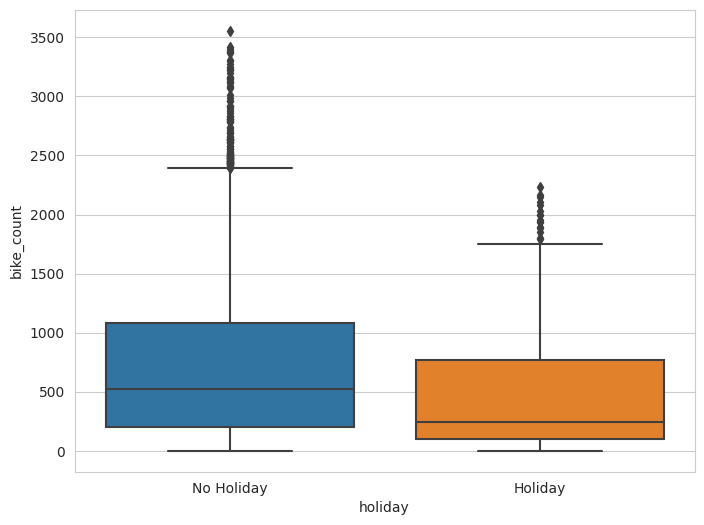

In [ ]:
# Boxplot for holiday:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'holiday')

plt.xlabel('holiday')
plt.ylabel('bike_count')

plt.show()

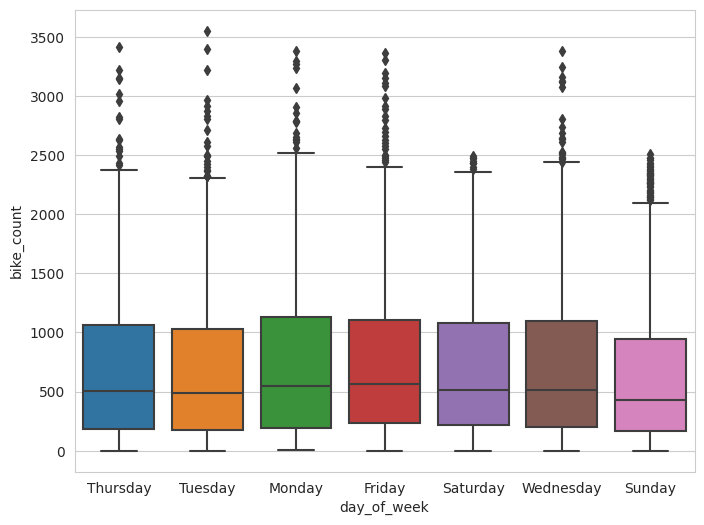

In [ ]:
# Boxplot for day_of_week:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'day_of_week')

plt.xlabel('day_of_week')
plt.ylabel('bike_count')

plt.show()

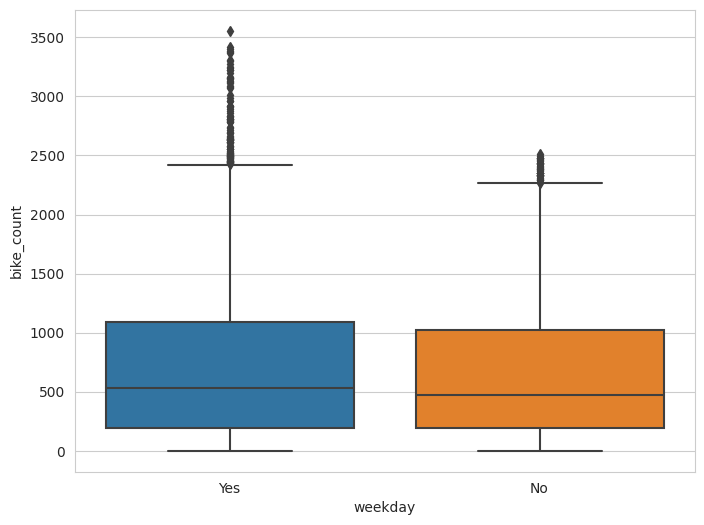

In [ ]:
# Boxplot for weekday:

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'weekday')

plt.xlabel('weekday')
plt.ylabel('bike_count')

plt.show()

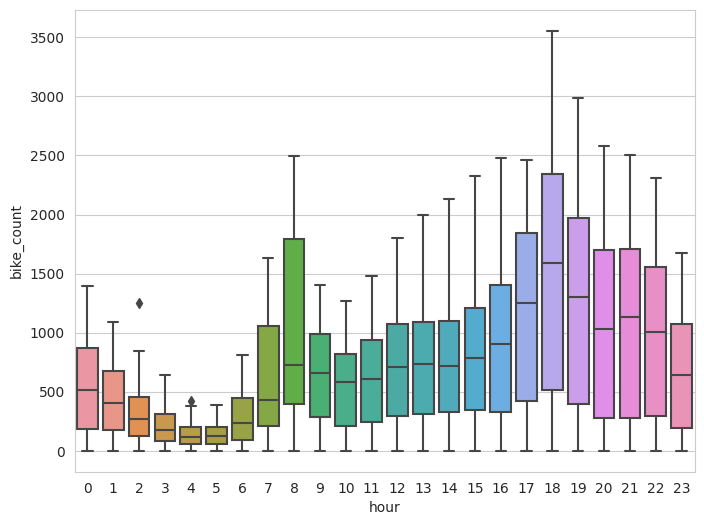

In [7]:
# Boxplot for hours

# peak at morning rush hours & evening (8am, 6pm)

plt.figure(figsize = (8,6))

sns.boxplot(data = bikes_train,
            y = 'bike_count',
            x = 'hour')

plt.xlabel('hour')
plt.ylabel('bike_count')

plt.show()

In [ ]:
# Importance of features using permutation_importance (see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) 

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = StandardScaler() 

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", numerical_pipe, continuous_features),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(#max_depth=5, 
                                             #max_samples=80, 
                                             #n_estimators=1000,
                                             random_state=614)),
    ]
)
rf.fit(bikes_train.drop(["date", "bike_count"], axis=1),
       bikes_train['bike_count'])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['season', 'holiday',
                                                   'functioning_day', 'weekday',
                                                   'day_of_week']),
                                                 ('num', StandardScaler(),
                                                  ['hour', 'temperature',
                                                   'humidity', 'wind_speed',
                                                   'visibility',
                                                   'dew_point_temp',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestRegressor(random_state=614))])

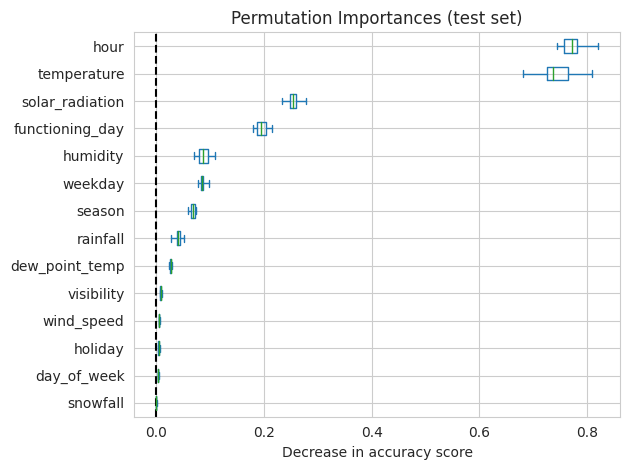

In [ ]:
result = permutation_importance(
    rf, 
    bikes_test.drop(["date", "bike_count"], axis=1), 
    bikes_test['bike_count'], 
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=bikes.drop(['date', 'bike_count'], axis=1).columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

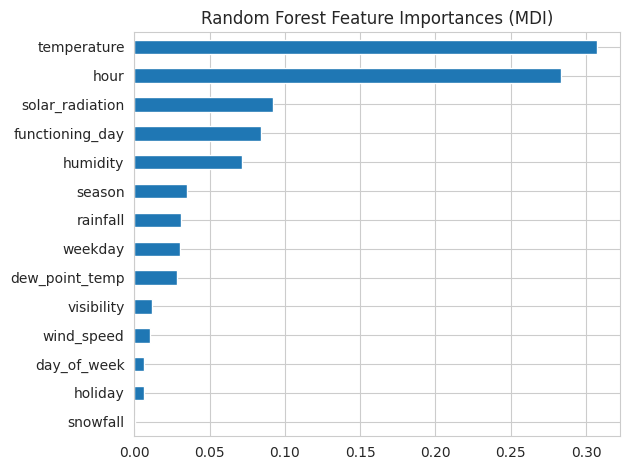

In [ ]:
# Feature Importance from Mean Decrease in Impurity (MDI)
# (from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

# Model Training

We try the following models:



*   Histogram-based Gradient Boosting Regression
*   XGBoosting Regression
*   Extra Trees Regression
*   Random Forest Regression
*   Support Vector Regression
*   KNN Regression
*   Voter Model

We tune hyperparameters for each model using GridSearchCV; see https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_grid_search.html





In [ ]:
# We use all features (we tried reducing the number of features, but the results weren't better)

chosen_continuous_features = continuous_features 
chosen_categorical_features = categorical_features 
chosen_features = chosen_continuous_features + chosen_categorical_features


In [ ]:
bikes_train[chosen_features]

hour  temperature  humidity  wind_speed  visibility  dew_point_temp  \
3190    22         13.5        15         2.2        2000           -12.6   
4650    18         24.9        53         3.6        2000            14.6   
7807     7          8.9        67         0.8        1557             3.0   
1526    14          3.2        26         2.2        1499           -14.5   
3967     7         16.2        79         1.2         239            12.5   
...    ...          ...       ...         ...         ...             ...   
5852    20         34.5        62         2.8        1701            26.1   
6049     1         26.9        84         0.2        1061            23.9   
2743     7          4.7        82         1.3         198             1.8   
5657    17         34.9        51         2.2        1235            23.2   
4951     7         22.1        74         0.3         830            17.2   

      solar_radiation  rainfall  snowfall  season     holiday functioning_day  \
3190             0.00       0.0       0.0  Spring  No Holiday             Yes   
4650             1.28       0.0       0.0  Summer  No Holiday             Yes   
7807             0.00       0.0       0.0  Autumn  No Holiday             Yes   
1526             1.16       0.0       0.0  Winter  No Holiday             Yes   
3967             0.36       0.0       0.0  Spring  No Holiday             Yes   
...               ...       ...       ...     ...         ...             ...   
5852             0.02       0.0       0.0  Summer  No Holiday             Yes   
6049             0.00       0.0       0.0  Summer  No Holiday             Yes   
2743             0.02       0.0       0.0  Spring  No Holiday             Yes   
5657             0.98       0.0       0.0  Summer  No Holiday             Yes   
4951             0.37       0.0       0.0  Summer  No Holiday             Yes   

     weekday day_of_week  
3190     Yes    Thursday  
4650     Yes     Tuesday  
7807     Yes      Monday  
1526     Yes      Friday  
3967     Yes     Tuesday  
...      ...         ...  
5852     Yes   Wednesday  
6049     Yes      Friday  
2743      No      Sunday  
5657     Yes     Tuesday  
4951     Yes      Monday  

[7008 rows x 14 columns]

In [ ]:
# Some pre-processing (relevant source: https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_grid_search.html)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

continuous_preprocessor = StandardScaler() 

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, chosen_categorical_features),
    ('cont_preprocessor', continuous_preprocessor, chosen_continuous_features)],
    remainder='passthrough', sparse_threshold=0)



## Histogram-based Gradient Boosting Regression




In [ ]:
HGB = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     HistGradientBoostingRegressor(random_state=42))])

# We will run grid search in several rounds. First run Round 1, then define the Round 2 param_grid depending on the results of Round 1, run round 2, etc.

# Round 1
param_grid_1 = {
    'regressor__learning_rate': [0.01, 0.1, 1, 10],
    'regressor__max_leaf_nodes': [45, 55, 60, 65, 70, 75, 80, 85],
    'regressor__l2_regularization': [0, 1, 2, 5]}
# Output: {'regressor__l2_regularization': 2, 'regressor__learning_rate': 0.1, 'regressor__max_leaf_nodes': 75}
# Neg MSE: -25081.007568452118

# Round 2
param_grid_2 = {
    'regressor__learning_rate': [0.05, 0.1, 0.15, 0.25, 0.35],
    'regressor__max_leaf_nodes': [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
    'regressor__l2_regularization': [1, 2, 3]}
# Output: {'regressor__l2_regularization': 2, 'regressor__learning_rate': 0.15, 'regressor__max_leaf_nodes': 74}
# Neg MSE: -24788.521384069172

# Let's stop here

HGB_grid_search = GridSearchCV(HGB, 
                               param_grid=param_grid_2,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=2, 
                               cv=5)

HGB_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'hu...
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'dew_point_temp',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall'])])),
                                       ('regressor',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=2,
             param_grid={'regressor__l2_regularization': [1, 2, 3],
                         'regressor__learning_rate': [0.05, 0.1, 0.15, 0.25,
                                                      0.35],
                         'regressor__max_leaf_nodes': [70, 71, 72, 73, 74, 75,
                                                       76, 77, 78, 79]},
             scoring='neg_mean_squared_error')

In [ ]:
print('best parameters for HGB: ' + str(HGB_grid_search.best_params_))
print('negative MSE score for HGB: ' + str(HGB_grid_search.best_score_))

best parameters for HGB: {'regressor__l2_regularization': 2, 'regressor__learning_rate': 0.15, 'regressor__max_leaf_nodes': 74}
negative MSE score for HGB: -24788.521384069172


## XGBoost Regression


In [ ]:
XGB = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, 
                              # tree_method='hist', # NOTE: I commented out this row after the final round of grid search. Commenting out this row after using those chosen hyperparameters yields better results
                              # I also tried to run 3 rounds of grid search WITHOUT tree_method='hist'. This took over 1.5 hours and the results were worse
                               subsample=0.9, # only use a random subset consisting of 90% of the data (may help prevent overfitting and speed up the process)
                              # colsample_bytree=0.5 # only use a random 50% subset of features per tree (may help prevent overfitting and speed up the process)
                              # (NOTE: I commented the above row out only after running Round 3 of the grid search. For rounds 1, 2, 3 it was un-commented out to speed up the process)
    )
    )
])

# We implement grid search in several rounds (because the process takes a long time). First run Round 1, then define the Round 2 param_grid depending on the results of Round 1, run round 2, etc.

# Round 1
param_grid_1 = {
    'regressor__learning_rate': [0.01, 0.1, 1],
    'regressor__max_depth': [6, 8, 10],
    'regressor__n_estimators': [500, 1000],
    'regressor__gamma': [0, 0.25, 1],
    'regressor__reg_lambda': [0, 1, 10]
}
# Round 1 output: {'regressor__gamma': 1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 1000, 'regressor__reg_lambda': 10}
# Neg MSE: -27075.2791

# Round 2
param_grid_2 = {
    'regressor__learning_rate': [0.05, 0.1, 0.5],
    'regressor__max_depth': [7, 8, 9],
    'regressor__n_estimators': [1000, 1200],
    'regressor__gamma': [1, 1.25, 1.5],
    'regressor__reg_lambda': [8, 10, 12]
}
# Round 2 output: {'regressor__gamma': 1.25, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 1200, 'regressor__reg_lambda': 10}
# Neg MSE: -26354.16952976146

# Round 3
param_grid_3 = {
    'regressor__learning_rate': [0.03, 0.05, 0.07],
    'regressor__max_depth': [7],
    'regressor__n_estimators': [1200, 1400],
    'regressor__gamma': [1.15, 1.25, 1.35],
    'regressor__reg_lambda': [9, 10, 11]
}
# Round 3 output: {'regressor__gamma': 1.25, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 1400, 'regressor__reg_lambda': 10}
# Neg MSE: -26331.9399231866

# No further significant improvements, so let's go with the parameters from Round 3

param_grid = {
    'regressor__learning_rate': [0.05],
    'regressor__max_depth': [7],
    'regressor__n_estimators': [1400],
    'regressor__gamma': [1.25],
    'regressor__reg_lambda': [10]
}

XGB_grid_search = GridSearchCV(XGB, 
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               n_jobs=10,
                               verbose=True,
                               cv=3) # I only used 3-fold cross-validation to speed up the process (but even with cv=3 it takes long)

XGB_grid_search.fit(bikes_train[chosen_features], bikes_train['bike_count'])


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'hu...
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=10,
             param_grid={'regressor__colsample_bytree': [0.5, 0.7, 0.9, 1],
                         'regressor__gamma': [1.25],
                         'regressor__learning_rate': [0.05],
                         'regressor__max_depth': [7],
                         'regressor__n_estimators': [1400],
                         'regressor__reg_lambda': [10]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
print('best parameters for XGB: ' + str(XGB_grid_search.best_params_))
print('negative MSE score for XGB: ' + str(XGB_grid_search.best_score_))

best parameters for XGB: {'regressor__colsample_bytree': 1, 'regressor__gamma': 1.25, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 1400, 'regressor__reg_lambda': 10}
negative MSE score for XGB: -24655.574387716435


## Extra Trees Regression


In [ ]:
ET = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     ExtraTreesRegressor(random_state=42))])


# Here I also did several rounds of grid search, but I'm skipping the details


param_grid = {
    'regressor__max_depth': [20, 22, 24], 
    'regressor__n_estimators': [1000, 1200, 1400], 
    }


ET_grid_search = GridSearchCV(ET, 
                               param_grid=param_grid,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=5, 
                               verbose = True,
                               cv=5)

ET_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])



Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'dew_point_temp',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall'])])),
                                       ('regressor',
                                        ExtraTreesRegressor(random_state=42))]),
             n_jobs=5,
             param_grid={'regressor__max_depth': [22],
                         'regressor__min_samples_leaf': [1, 2, 3],
                         'regressor__n_estimators': [1200]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
print('best parameters for ET: ' + str(ET_grid_search.best_params_))
print('negative MSE score for ET: ' + str(ET_grid_search.best_score_))

best parameters for ET: {'regressor__max_depth': 22, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 1200}
negative MSE score for ET: -25916.250075636075


## Random Forest Regression

In [ ]:
RF = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor",
     RandomForestRegressor(random_state=42))])

# Here I also did several rounds of grid search, but I'm skipping the details

param_grid = {
    'regressor__max_depth': [18, 20, 22], 
    'regressor__n_estimators': [600, 800, 1000]
    }

RF_grid_search = GridSearchCV(RF, 
                               param_grid=param_grid,
                               scoring = 'neg_mean_squared_error',
                               n_jobs=5, 
                               verbose = True,
                               cv=5)

RF_grid_search.fit(bikes_train[chosen_features],
       bikes_train['bike_count'])


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'dew_point_temp',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=5,
             param_grid={'regressor__max_depth': [18, 20, 22],
                         'regressor__n_estimators': [600, 800, 1000]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
print('best parameters for RF: ' + str(RF_grid_search.best_params_))
print('negative MSE score for RF: ' + str(RF_grid_search.best_score_))

best parameters for RF: {'regressor__max_depth': 20, 'regressor__n_estimators': 800}
negative MSE score for RF: -31786.92086666519


## Support Vector Regression

In [ ]:
SVR = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", SVR())
])

# Here I also did several rounds of grid search, but I'm skipping the details

param_grid = {
    'regressor__C': [40, 50, 60],  # Penalty parameter C
    'regressor__kernel': ['linear', 'rbf'],  # Kernel function
    'regressor__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly'
    'regressor__epsilon': [0.3, 0.4, 0.5, 0.6]  # Epsilon in the epsilon-insensitive loss function
}

SVR_grid_search = GridSearchCV(SVR,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               n_jobs=5,
                               cv=5)

SVR_grid_search.fit(bikes_train[chosen_features], bikes_train['bike_count'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'dew_point_temp',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall'])])),
                                       ('regressor', SVR())]),
             n_jobs=5,
             param_grid={'regressor__C': [40, 50, 60],
                         'regressor__epsilon': [0.3, 0.4, 0.5, 0.6],
                         'regressor__gamma': ['scale', 'auto'],
                         'regressor__kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [ ]:
print('best parameters for SVR: ' + str(SVR_grid_search.best_params_))
print('negative MSE score for SVR: ' + str(SVR_grid_search.best_score_))

best parameters for SVR: {'regressor__C': 60, 'regressor__epsilon': 0.3, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
negative MSE score for SVR: -136574.75864468157


## KNeighbors Regression

In [ ]:
KNN = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", KNeighborsRegressor())
])

param_grid = {
    'regressor__n_neighbors': list(range(1, 20, 1)),
    'regressor__weights': ['uniform', 'distance']
}

KNN_grid_search = GridSearchCV(KNN, 
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               n_jobs=2, 
                               cv=5)

KNN_grid_search.fit(bikes_train[chosen_features],
                    bikes_train['bike_count'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['season',
                                                                          'holiday',
                                                                          'functioning_day',
                                                                          'weekday',
                                                                          'day_of_week']),
                                                                        ('cont_preprocessor',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'temperature',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'visibility',
                                                                          'dew_point_temp',
                                                                          'solar_radiation',
                                                                          'rainfall',
                                                                          'snowfall'])])),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=2,
             param_grid={'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19],
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
print('best parameters for KNN: ' + str(KNN_grid_search.best_params_))
print('negative MSE score for KNN: ' + str(KNN_grid_search.best_score_))

best parameters for KNN: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
negative MSE score for KNN: -99426.78022327066


## Voting Regression and model selection



In [ ]:
# Split the training set further to get a validation set

bikes_tt, bikes_val = train_test_split(bikes_train,
                              shuffle=True,
                              random_state=3222,
                              test_size=0.2)

In [ ]:
# Define the regressors with the hyperparameters chosen by the grid searches above
HGB_regressor = HGB_grid_search.best_estimator_['regressor']
XGB_regressor = XGB_grid_search.best_estimator_['regressor']
RF_regressor = RF_grid_search.best_estimator_['regressor']
ET_regressor = ET_grid_search.best_estimator_['regressor']
SVR_regressor = SVR_grid_search.best_estimator_['regressor']
KNN_regressor = KNN_grid_search.best_estimator_['regressor']


# Create the Voting Regressor
vote_regressor = VotingRegressor(
    estimators=[
        ('hgb', HGB_regressor), 
        ('xgb', XGB_regressor),
        ('rf', RF_regressor),
     #   ('svr', SVR_regressor), I left out SVR because it makes the voter model worse
     #   ('knn', KNN_regressor)  I left out KNN because it makes the voter model worse
         ],
)

# Create the pipeline with the preprocessor and the Voting Regressor
vote_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", vote_regressor)
])

# Pipeline with HGB_regressor
hgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", HGB_regressor)
])

# Pipeline with XGB_regressor:
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGB_regressor)
])

# Pipeline with ET_regressor:
et_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ET_regressor)
])

# Pipeline with RF_regressor:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RF_regressor)
])

# Pipeline with SVR_regressor:
svr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", SVR_regressor)
])

# Pipeline with KNN_regressor:
knn_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", KNN_regressor)
])






In [ ]:
# Fit the pipelines to the training data
vote_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
hgb_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
xgb_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
et_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
rf_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
svr_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])
knn_pipeline.fit(bikes_tt[chosen_features], bikes_tt['bike_count'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['season', 'holiday',
                                                   'functioning_day', 'weekday',
                                                   'day_of_week']),
                                                 ('cont_preprocessor',
                                                  StandardScaler(),
                                                  ['hour', 'temperature',
                                                   'humidity', 'wind_speed',
                                                   'visibility',
                                                   'dew_point_temp',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall'])])),
                ('regressor',
                 KNeighborsRegressor(n_neighbors=3, weights='distance'))])

In [ ]:
# Get predictions on the validation set
vote_pred = vote_pipeline.predict(bikes_val[chosen_features])
hgb_pred = hgb_pipeline.predict(bikes_val[chosen_features])
xgb_pred = xgb_pipeline.predict(bikes_val[chosen_features])
et_pred = et_pipeline.predict(bikes_val[chosen_features])
rf_pred = rf_pipeline.predict(bikes_val[chosen_features])
svr_pred = svr_pipeline.predict(bikes_val[chosen_features])
knn_pred = knn_pipeline.predict(bikes_val[chosen_features])



In [ ]:
vote_mse = mean_squared_error(bikes_val['bike_count'], vote_pred)
hgb_mse = mean_squared_error(bikes_val['bike_count'], hgb_pred)
xgb_mse = mean_squared_error(bikes_val['bike_count'], xgb_pred)
et_mse = mean_squared_error(bikes_val['bike_count'], et_pred)
rf_mse = mean_squared_error(bikes_val['bike_count'], rf_pred)
svr_mse = mean_squared_error(bikes_val['bike_count'], svr_pred)
knn_mse = mean_squared_error(bikes_val['bike_count'], knn_pred)

# Create a DataFrame
mse_df = pd.DataFrame({
    'Regressor': ['Voter', 'HGB', 'XGB', 'ET', 'RF', 'SVR', 'KNN'],
    'MSE': [vote_mse, hgb_mse, xgb_mse, et_mse, rf_mse, svr_mse, knn_mse]
})

# Sort the DataFrame by MSE in ascending order
mse_df = mse_df.sort_values(by='MSE', ascending=True)

In [ ]:
print('MSEs on the validation set:')
print()
mse_df

MSEs on the validation set:



Regressor            MSE
2       XGB   23178.210901
0     Voter   23780.430148
1       HGB   24689.983933
3        ET   25194.869371
4        RF   32022.426478
6       KNN  108144.778677
5       SVR  141993.153056

In [ ]:
# Now let's fit the best models on the entire training set and see how well they do on the entire testing set
# We disregard RF, KNN, SVR since they seem to be much worse than the others

# XGBoost
xgb_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
xgb_predict = xgb_pipeline.predict(bikes_test[chosen_features])
print('MSE of XGB on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], xgb_predict)))

# Voter
vote_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
vote_predict = vote_pipeline.predict(bikes_test[chosen_features])
print('MSE of Voter on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], vote_predict)))

# HGBoost
hgb_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
hgb_predict = hgb_pipeline.predict(bikes_test[chosen_features])
print('MSE of HGB on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], hgb_predict)))

# ET
et_pipeline.fit(bikes_train[chosen_features], bikes_train['bike_count'])
et_predict = et_pipeline.predict(bikes_test[chosen_features])
print('MSE of ET on the entire testing set: ' + str(mean_squared_error(bikes_test['bike_count'], et_predict)))


MSE of XGB on the entire testing set: 23464.66243684614
MSE of Voter on the entire testing set: 24296.117394809782
MSE of HGB on the entire testing set: 25708.27950378138
MSE of RT on the entire testing set: 27369.80028362249


Out of the three models above, ET seem to be overfitting most. XGB and Voter overfit the least. 